cuda GeForce RTX 2070
(900, 1440, 3)


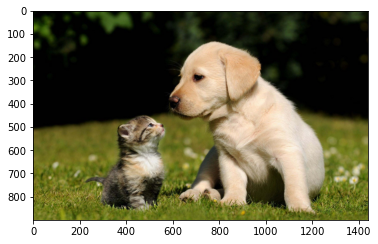

In [2]:

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

from PIL import Image


if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

#-----Read training image along with their bounding boxes and lables-----
img0 = cv2.imread('catdog.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
print(img0.shape)
plt.imshow(img0)
plt.show()

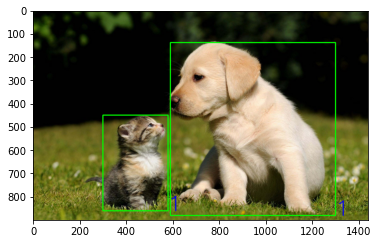

In [3]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
bbox0 = np.array([[450, 300, 860, 580], [139, 590, 880, 1300]]) 
labels = np.array([1, 1]) # 0: background, 1: cat, 2: dog

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()    

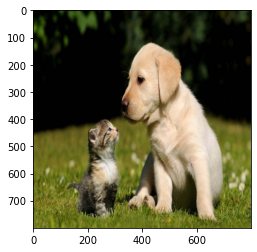

In [4]:
#-----Resize the input images to (h=800, w=800)-----
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()


In [5]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)




[[400 166 764 322]
 [123 327 782 722]]


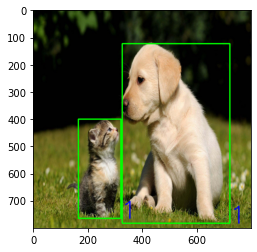

In [6]:
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()    


In [7]:
#-----Use VGG16 to extract features from input image-----
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [8]:

# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
print(k.size()[2])
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512





torch.Size([1, 3, 800, 800])
800
30
512


In [9]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

# 測試看看 input image 通過 feature extractor 的結果
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
#use dataloader
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())


torch.Size([1, 512, 50, 50])


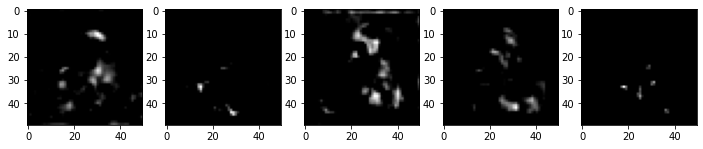

In [10]:
# visualize the first 5 channels of the 50*50*512 feature maps
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()


In [11]:
# -----Generate 22,500 anchor boxes on each input image----- 
# 50x50=2500 anchors, each anchor generate 9 anchor boxes, Total = 50x50x9=22,500 

# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)


50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [12]:

# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


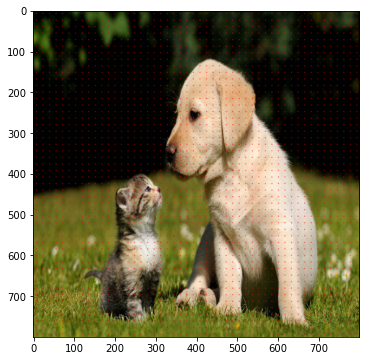

In [13]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_clone)
plt.show()    




In [14]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


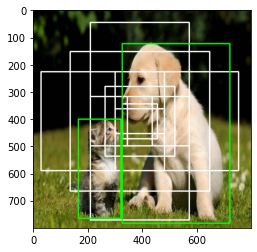

In [15]:

# display the 9 anchor boxes of one anchor and the ground trugh bbox
img_clone = np.copy(img)
for i in range(11025, 11034):  #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  


In [16]:
#-----計算每個 valid anchor boxe 與 ground truth bboxes 的 iou-----
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)




(8940,)
(8940, 4)


In [17]:

# Calculate iou of the valid anchor boxes 
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
print(ious.shape)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)




(8940, 2)
(8940, 2)


In [18]:
# What anchor box has max iou with the ground truth bbox  
gt_argmax_ious = ious.argmax(axis=0) #axis0是行对比找最大，就是第一列的1931行和第二列的6386行
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]# np.arange(3)->array([0, 1, 2]) ,索引ious[[1931,6386],[0,1]] 刚才用8940个valid box，每一个分别与2个gtbox计算iou，于是有(8940, 2)。然后这里就是，其中第一列对应的gtbox的iou最大的那个是1931行的iou，与第二列gtbox对应的iou最大的推测box是第2列6386行的那个iou。

print(gt_max_ious)#这里输出的就是1列1931行的iou数值和2列6386行的iou数值

gt_argmax_ious = np.where(ious == gt_max_ious)[0]#这里输出第一列的1931行和2159行，第二列的6386行和6632行。因为之前找到最大的数值，这次找对应的行，但是有重复，所以最后出来的是第一列的2行和第二列的2行总共4个对应的iou最大的预测box

print(gt_argmax_ious)#所以这里就知道每个gtbox对应预测box的行数

# a = np.array(([2,4],[7,2],[3,5],[7,8]))
# print(a.argmax(axis=0))
# print(a[[1,3],[0,1]])
# print(np.where(a==[7,8]))
# print(a.shape)


[1931 6386]
[0.8533057 0.8404807]
[1931 2159 6386 6632]


In [19]:

# What ground truth bbox is associated with each anchor box 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]#len(index_inside)=8940
print(max_ious)




(8940,)
[0 0 0 ... 1 1 1]
[0.         0.         0.         ... 0.01544915 0.01544915 0.01505847]


In [20]:
#-----依據 iou 值來設定 8940 個 valid anchor boxes 的標籤, 1: object, 0: background, -1: ignore-----
#  把 8940 個 valid anchor boxes 的標籤先統一設為 -1 (ignore)
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [21]:

# Use iou to assign 1 (objects) to two kind of anchors 
# a) The anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1

label[max_ious >= pos_iou_threshold] = 1

label[max_ious < neg_iou_threshold] = 0
# c=0
# for i in label:
#     if i == 1:
#         c=c+1
# print(c)




In [22]:
#-----每次 mini-batch training 只取 256 個 valid anchor boxes 來訓練 RPN, 其中 128 positive examples, 128 negative examples (標籤 0), , 其他的 valid anchor boxes 的標籤在本次 mini-batch training 改回 -1 (ignore)-----
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)

neg_index = np.where(label == 0)[0]


if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1


In [23]:
#把 valid anchor boxes 的 format 從 (y1, x, y2, x2) 轉成 loc = (cy-cya/ha), (cx-cxa/wa), log(h/ha), log(w/wa),
#  For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# valid anchor boxes 的 h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# valid anchor box 的 max iou 的 bbox 的 h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #讓 height !=0, 最小值為 eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height #
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)


(8940, 4)
(8940, 4)


In [24]:
#先把 22500 個 anchor boxes 的 label=-1 , locations=0, 再填上 8940 個 valid anchor boxes 的 locations 與 labels
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(index_inside.shape)
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)




(8940,)
(22500,)
(22500, 4)


In [25]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
print(conv1.bias.shape)

conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
print(conv1.bias.data.zero_().shape)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
print(reg_layer.bias.data.zero_().shape)
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()
print(cls_layer.bias.data.zero_().shape)

torch.Size([512])
torch.Size([512])
torch.Size([36])
torch.Size([18])


In [26]:

x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor) torch.Size([1, 512, 50, 50])
print(x.shape)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)





torch.Size([1, 512, 50, 50])
torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [27]:
# 轉換 RPN 預測 anchor box 的位置與分類之 format 
# 位置: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# 分類: [1, 18(9*2), 50, 50] => [1, 22500, 2]  (1, 0)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [28]:
#依據 RPN 預測的22500 個ROIs, 以及 22500 個 anchor boxes, 計算 RPN loss¶

print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)


rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]


gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)
torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [29]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6964, device='cuda:0', grad_fn=<NllLossBackward>)


In [30]:

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
print(pos.shape)
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(rpn_loc.shape)
print(mask.shape)

# take those bounding boxes which have positve labels
print(rpn_loc[mask].shape)
print(gt_rpn_loc[mask].shape)
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())




torch.Size([22500])
torch.Size([22500, 4])
torch.Size([22500, 4])
torch.Size([140])
torch.Size([140])
torch.Size([35, 4]) torch.Size([35, 4])
tensor(0.7281, dtype=torch.float64, grad_fn=<SumBackward0>)


In [31]:

# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(0.9044, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
